In [1]:
import functools
import glob
import os

In [2]:
import coord
import fitsio
import galsim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from sklearn.neighbors import KNeighborsRegressor

In [3]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

In [4]:
truth_catalog = "/global/cfs/cdirs/desbalro/input_cosmos_v4.fits"

In [5]:
deepfield_catalog = "/global/cfs/cdirs/desbalro/DES_DF_COSMOS.fits"

In [6]:
truth_table = fitsio.read(truth_catalog)
truth_id = truth_table["des_id"]

In [7]:
deepfield_table = fitsio.read(deepfield_catalog)
deepfield_id = deepfield_table["ID_DES"]

In [8]:
_, truth_indices, df_indices = np.intersect1d(
    truth_id,
    deepfield_id,
    return_indices=True,
)

In [9]:
# assert magnitudes are equal
for band in ["g", "r", "i", "z"]:
    np.testing.assert_allclose(
        truth_table[truth_indices][f"mag_{band}"],
        deepfield_table[df_indices][f"MAG_{band}"],
    )

In [10]:
# assert magnitudes transform to fluxes ok
for band in ["g", "r", "i", "z"]:
    _df_flux = np.power(
        10,
        -0.4 * (deepfield_table[df_indices][f"MAG_{band}"] - 30),
    )
    np.testing.assert_allclose(
        truth_table[truth_indices][f"flux_{band}"],
        _df_flux,
    )


In [11]:
df_flux = np.power(
    10,
    -0.4 * (deepfield_table[df_indices]["MAG_r"] - 30),
)
df_flux_err = np.power(
    10,
    -0.4 * (deepfield_table[df_indices]["ERR_MAG_r"] - 30),
)

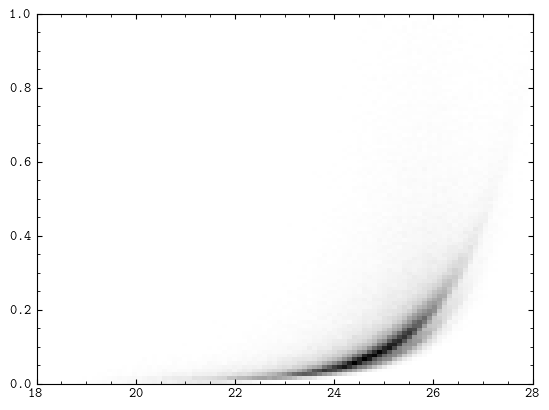

In [12]:
plt.hist2d(
    deepfield_table[df_indices]["MAG_r"],
    deepfield_table[df_indices]["ERR_MAG_r"],
    bins=[np.linspace(18, 28, 100), np.linspace(0, 1, 100)],
)
plt.show()

$$ f = 10^{-(m - 30) / 2.5} $$

$$ \sigma_f^2 = \left(\frac{\partial f}{\partial m}\right)^2 \sigma_m^2 $$

$$ \frac{\partial f}{\partial m} = -\frac{1}{2.5} \ln 10 \times 10^{-(m - 30) / 2.5} $$


$$ \sigma_f^2 = \left(-\frac{1}{2.5} \ln 10 \times 10^{-(m - 30) / 2.5}\right)^2 \sigma_m^2 $$
$$ \sigma_f = \frac{\ln 10}{2.5} \times 10^{-(m - 30) / 2.5} \sigma_m $$

In [13]:
df_flux = np.power(
    10,
    -0.4 * (deepfield_table[df_indices]["MAG_r"] - 30),
)

In [14]:
df_flux_err = np.log(10) / 2.5 * np.power(
    10,
    -0.4 * (deepfield_table[df_indices]["MAG_r"] - 30),
) * deepfield_table[df_indices]["ERR_MAG_r"]

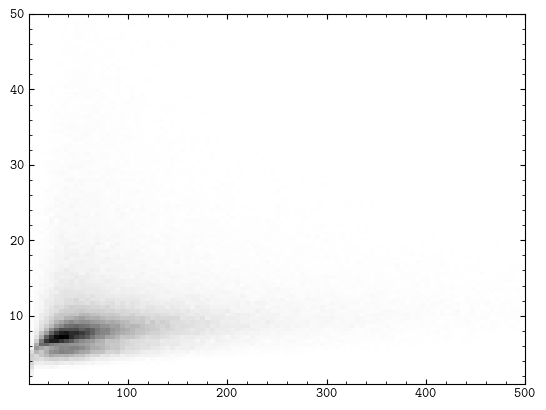

In [15]:
plt.hist2d(
    df_flux,
    df_flux_err,
    bins=[np.linspace(1, 500, 100), np.linspace(1, 50, 100)],
)
plt.show()

In [16]:
TRUTH_BANDS = ["u", "g", "r", "i", "z", "Y", "J",  "H", "Ks"]
DEEPFIELD_BANDS = ["u", "g", "r", "i", "z", "Y", "J", "H", "K"]

In [17]:
# assert magnitudes transform to fluxes ok
table = {}
for band in DEEPFIELD_BANDS:
    
    _mag = deepfield_table[df_indices][f"MAG_{band}"]
    _mag_err = deepfield_table[df_indices][f"ERR_MAG_{band}"]
    
    _flux = np.power(
        10,
        -(_mag - 30) / 2.5,
    )
    _flux_err = np.log(10) / 2.5 * _flux * _mag_err
    
    table[f"flux_{band}"] = _flux
    table[f"flux_err_{band}"] = _flux_err

In [18]:
_X = np.array(
    [
        table[f"flux_{band}"]
        for band in DEEPFIELD_BANDS
    ]
).T

_y = np.array(
    [
        table[f"flux_err_{band}"]
        for band in DEEPFIELD_BANDS
    ]
).T

In [19]:
# knn with distance weighting
knn = KNeighborsRegressor(weights="distance")

In [20]:
n_train = len(_X)  * 3 // 4

In [21]:
knn.fit(
    _X[:n_train],
    _y[:n_train],
)

KNeighborsRegressor(weights='distance')

In [22]:
y_pred = knn.predict(_X[n_train:])
y_true = _y[n_train:]

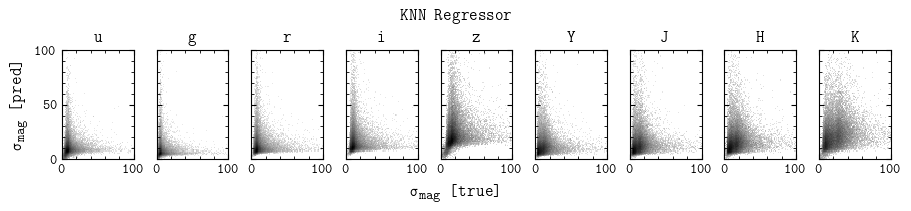

In [23]:
fig, axs = plt.subplots(1, len(DEEPFIELD_BANDS), sharex=True, sharey=True, constrained_layout=True, figsize=(9, 2))

for i, band in enumerate(DEEPFIELD_BANDS):
    axs[i].hist2d(
        y_true[:, i],
        y_pred[:, i],
        bins=[np.linspace(0, 100, 101), np.linspace(0, 100, 101)],
        norm="log",
    )

    axs[i].set_title(band)

fig.supylabel("$\\sigma_{mag}$ [pred]")
fig.supxlabel("$\\sigma_{mag}$ [true]")
fig.suptitle("KNN Regressor")

plt.show()

Note that this doesn't have to perform amazingly because *most* objects are present in both catalogs; there is a small number of edge cases I want to guard against